In [1]:
from optimizer import Optimizer
from heuristics import * 
import random 
import numpy as np 
import pandas as pd
from visualization import *
import random
import colorsys

In [2]:
random.seed(42)
np.random.seed(42)

In [3]:
def generate_distinct_colors(n):
    hues = [i / n for i in range(n)]
    random.shuffle(hues)
    
    colors = []
    saturation = 0.7  # Adjust between 0 (gray) and 1 (fully saturated)
    value = 0.9       # Adjust between 0 (black) and 1 (full brightness)
    
    for h in hues:
        r, g, b = colorsys.hsv_to_rgb(h, saturation, value)
        hex_color = f'#{int(r * 255):02x}{int(g * 255):02x}{int(b * 255):02x}'
        colors.append(hex_color)
    
    return colors

In [4]:
def get_dynamic_parameters(num_parts, color_variety):

    num_colors = int(num_parts * color_variety)
    num_colors = num_colors if num_colors != 0 else 1

    print(num_parts, num_colors)

    max_time_machine_A = ( 8 * 60 * 60)
    max_time_machine_B = ( 7 * 60 * 60)

    unit_production_time = 80
    cleaning_time = 80
    machines = [1,2]

    demand = {p: int((max_time_machine_A + max_time_machine_B) / (unit_production_time * (num_parts + 1 + color_variety))) for p in range(1, num_parts + 1)}

    demand[num_parts + 1] = 0
    demand[num_parts + 2] = 0

    colors = generate_distinct_colors(num_colors)
    parts_colors = {i: colors[(i - 1) % len(colors)] for i in range(1, num_parts + 1)}

    alpha = [[abs(1 - (parts_colors[p] == parts_colors[q])) for q in range(1, num_parts + 1)] for p in range(1, num_parts + 1)]

    return {
        "num_parts": num_parts,
        "max_time_machine_A": max_time_machine_A,
        "max_time_machine_B": max_time_machine_B,
        "demand": demand,
        "parts_colors": parts_colors,
        "alpha": alpha,
        "unit_production_time": unit_production_time,
        "cleaning_time": cleaning_time,
        "machines": machines,
    }

# Analyze the affect of the number of part sytles  

In [5]:
results = []

In [6]:
for color_varietry in [0, 0.5, 1]:
    for num_parts in [10, 20]:    
        problem_parameters = get_dynamic_parameters(num_parts, color_varietry)
        optimizer = Optimizer(**problem_parameters)
        model, objective_value, optimization_time = optimizer(verbose=False)
        results.append([num_parts, color_varietry, round(optimization_time, 4)])

results_df = pd.DataFrame(results, columns=["Number of Parts", "Color Variety", "Time"])

10 1
Set parameter Username
Set parameter LicenseID to value 2581974
Academic license - for non-commercial use only - expires 2025-11-11
20 1
10 5
20 10
10 10
20 20


In [7]:
results_df

,Number of Parts,Color Variety,Time
0,10,0.0,0.0066
1,20,0.0,0.3360
2,10,0.5,0.0325
3,20,0.5,0.3140
4,10,1.0,0.0275
5,20,1.0,0.0376


# Analyze the affect of the number of colors

In [8]:
results = []    

## Visualize Results and Example Solutions 

15 15


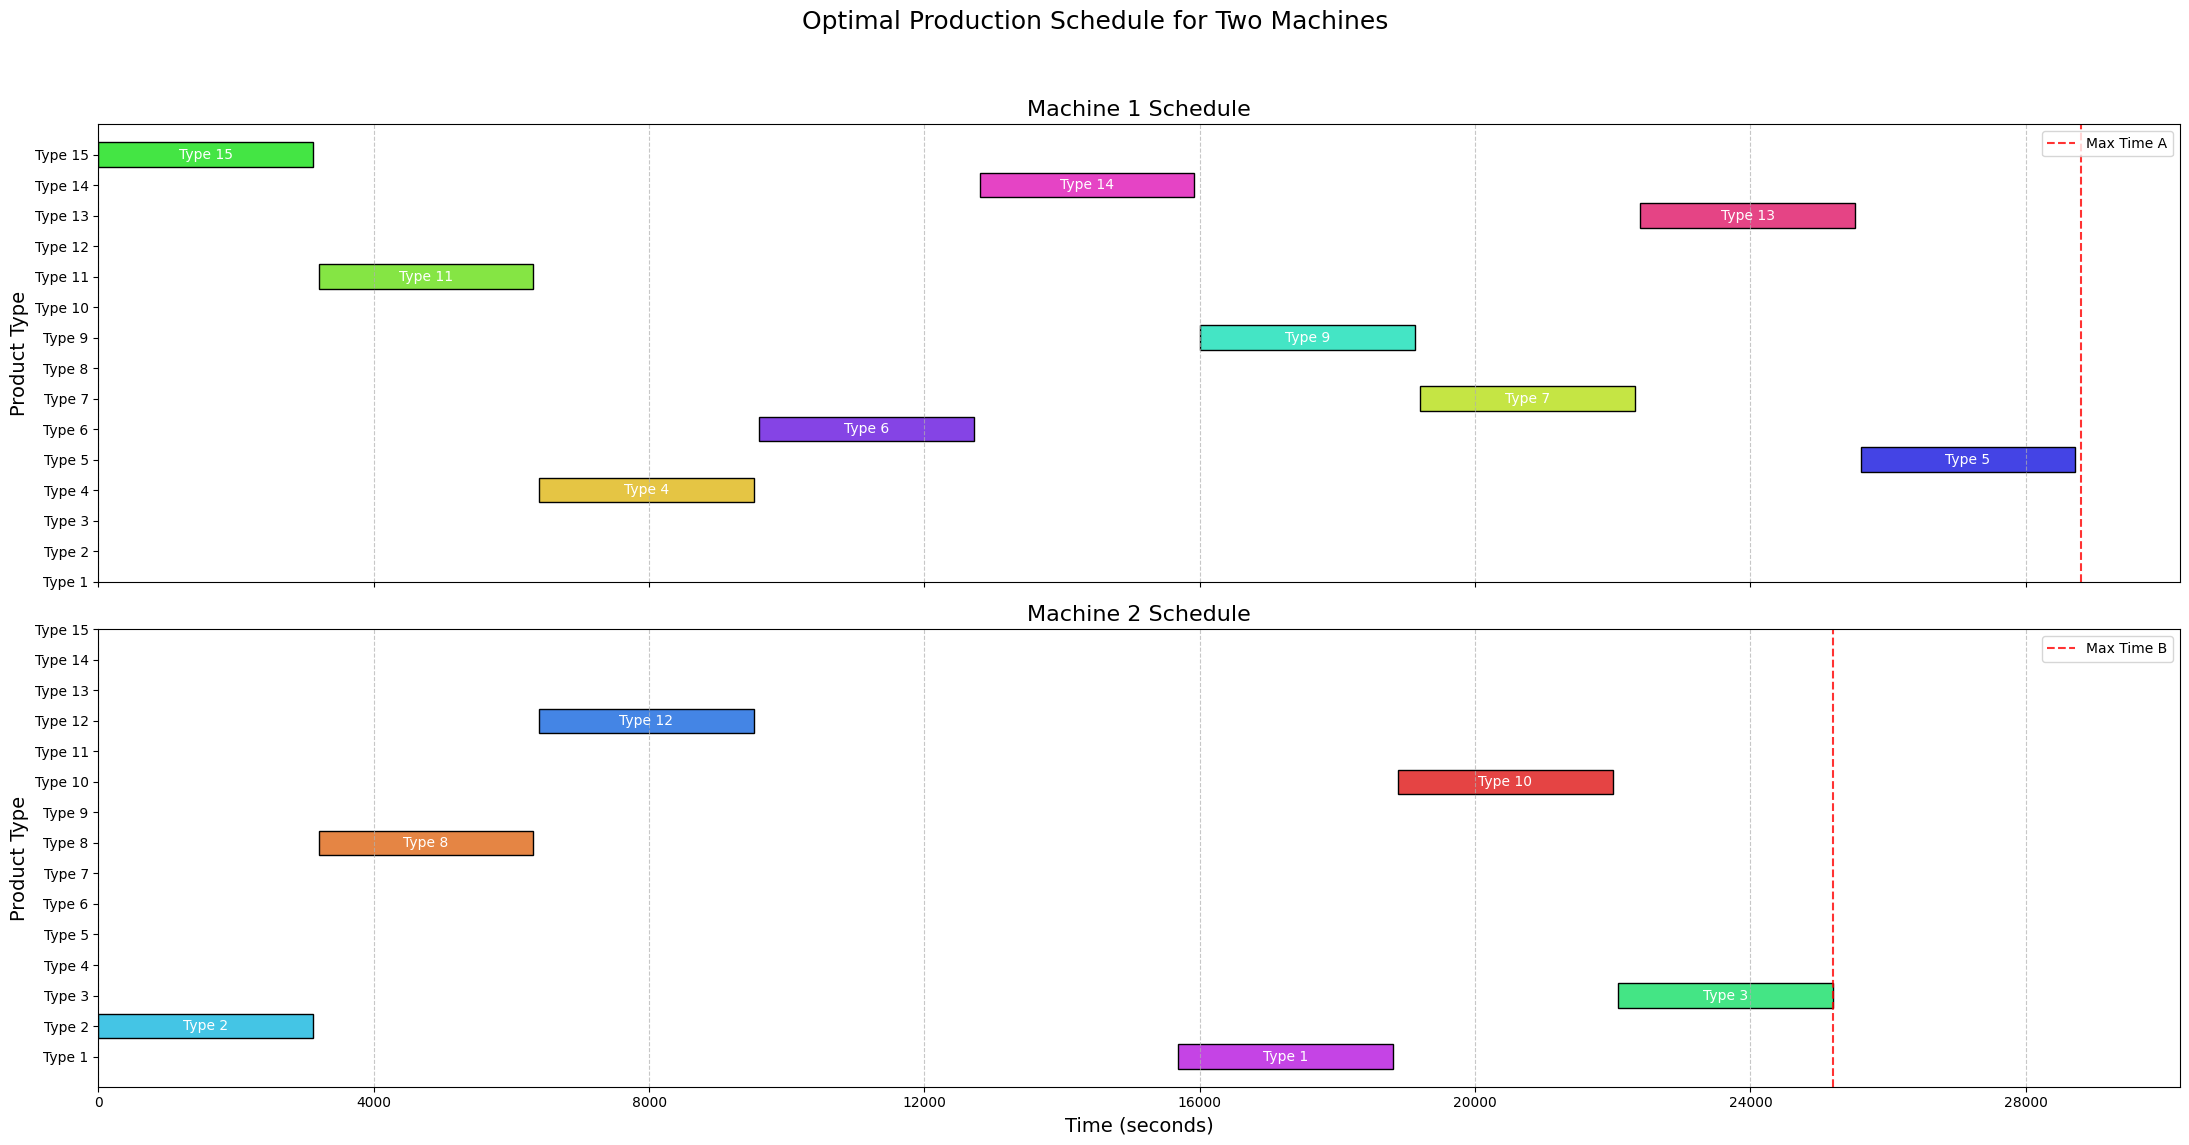

In [9]:
problem_parameters = get_dynamic_parameters(15, 1)
optimizer = Optimizer(**problem_parameters)
model, objective_value, optimization_time = optimizer(verbose=False)
optimizer.visualize()

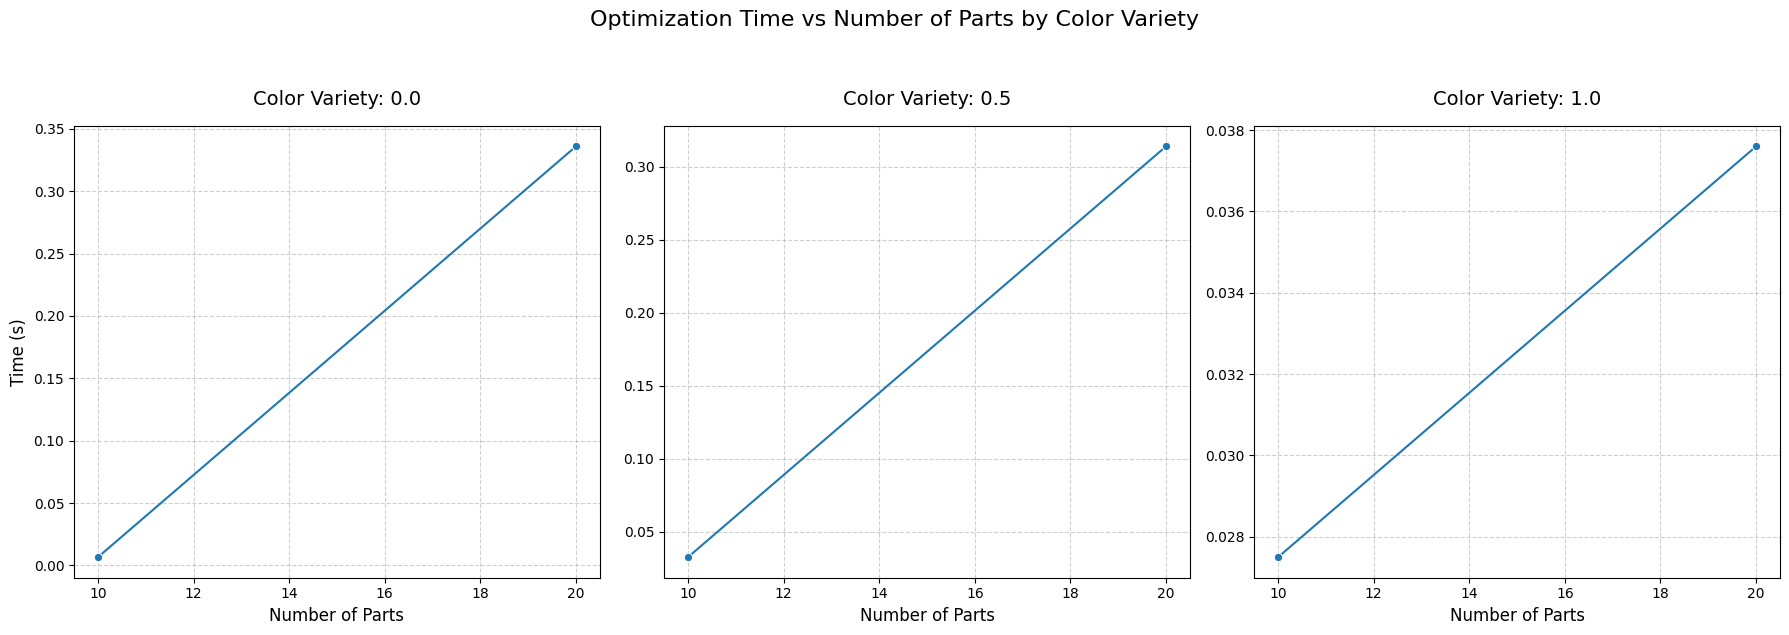

In [10]:
parameter_line_graph(results_df)